<a href="https://colab.research.google.com/github/bwowby/DS/blob/master/predict_stock_naver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import pandas_datareader.data as pdr

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation

In [7]:
# naver 주식 데이터 가져오기
naver = pdr.get_data_yahoo('035420.KS')
naver.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-22,295000.0,282000.0,290500.0,284500.0,864846.0,284500.0
2020-09-23,298000.0,285500.0,290000.0,296500.0,984136.0,296500.0
2020-09-24,295500.0,287000.0,291500.0,294000.0,848971.0,294000.0
2020-09-25,297500.0,289500.0,296000.0,295000.0,648182.0,295000.0
2020-09-28,302000.0,296000.0,297000.0,298500.0,704461.0,298500.0


In [9]:
# 네이버 주식 데이터 전처리, 분할, 모델 학습
high_prices = naver['High'].values
low_prices = naver['Low'].values
mid_prices = (high_prices + low_prices)/2

In [10]:
# 주가의 중간 값 계산
naver['Mid'] = mid_prices

In [11]:
# 종가의 5일 이동 평균값 계산 후 주가 데이터 추가
ma5 = naver['Adj Close'].rolling(window=5).mean()
naver['MA5'] = ma5

In [12]:
# 비어있는 값 0으로 바꾸기
naver = naver.fillna(0)

In [14]:
# index 있으니까 Datatime 값 지우기
naver = naver.reset_index(drop = True)
naver.head()

,High,Low,Open,Close,Volume,Adj Close,Mid,MA5
0,103000.0,100000.0,103000.0,102600.0,652740.0,99875.031250,101500.0,0.000000
1,109200.0,102600.0,103600.0,109200.0,1004490.0,106299.742188,105900.0,0.000000
2,110200.0,107000.0,110000.0,110000.0,702940.0,107078.484375,108600.0,0.000000
3,112600.0,107400.0,109800.0,108600.0,535860.0,105715.679688,110000.0,0.000000
4,111600.0,108400.0,109000.0,111200.0,592725.0,108246.617188,110000.0,105443.110937


In [19]:
# 데이터 스케일링 : 각 feature들이 동일한 범위(0~1)가지도록 스케일링
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(naver)
print(fitted.data_min_, fitted.data_max_)

[103000.      100000.      103000.      102600.           0.
  99875.03125 101500.           0.     ] [ 347000.  336500.  337000.  339000. 5304519.  339000.  341750.  330300.]


In [17]:
output = min_max_scaler.transform(naver)
output = pd.DataFrame(output, columns = naver.columns, index=list(naver.index.values))
output

,High,Low,Open,Close,Volume,Adj Close,Mid,MA5
0,0.000000,0.000000,0.000000,0.000000,0.123054,0.000000,0.000000,0.000000
1,0.025410,0.010994,0.002564,0.027919,0.189365,0.026868,0.018314,0.000000
2,0.029508,0.029598,0.029915,0.031303,0.132517,0.030124,0.029553,0.000000
3,0.039344,0.031290,0.029060,0.025381,0.101020,0.024425,0.035380,0.000000
4,0.035246,0.035518,0.025641,0.036379,0.111740,0.035009,0.035380,0.319234
...,...,...,...,...,...,...,...,...
1217,0.786885,0.769556,0.801282,0.769459,0.163039,0.772086,0.778356,0.897366
1218,0.799180,0.784355,0.799145,0.820220,0.185528,0.822269,0.791883,0.891008
1219,0.788934,0.790698,0.805556,0.809645,0.160047,0.811814,0.789802,0.887072
1220,0.797131,0.801268,0.824786,0.813875,0.122194,0.815996,0.799168,0.885256


In [21]:
# 트레인 셋/테스트셋 크기 설정
train_size = int(len(output)*0.6)
test_size = int(len(output)*0.3) + train_size

In [33]:
# train/test 라벨 설정
train_x = np.array(output[:train_size])
train_y = np.array(output['Close'][:train_size])
test_x = np.array(output[train_size:test_size])
test_y = np.array(output['Close'][train_size:test_size])
validation_x = np.array(output[test_size:])
validation_y = np.array(output['Close'][test_size:])

In [25]:
# Keras 모델 생성
model = Sequential()

In [26]:
# 모델 학습 위한 파라미터 설정 -> 하이퍼 파라미터?
learning_rate = 0.01
training_cnt = 1000
batch_size = 100
input_size = 8

In [29]:
# 생성된 모델에 학습용 데이터(train_x) 넣기 -> 왜 세번해주는 걸까...
model.add(Dense(input_size, activation='tanh', input_shape=(train_x.shape[1],)))
model.add(Dense(input_size*3, activation='tanh'))
model.add(Dense(1,activation='tanh'))

In [34]:
# 데이터 학습 진행
model.compile(optimizer='sgd', loss='mse', metrics=['mae','mape','acc'])
model.summary()

history = model.fit(train_x, train_y, epochs=training_cnt, batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape, val_acc = model.evaluate(test_x, test_y, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.9808e-05 - mae: 0.0060 - mape: 14225.5010 - acc: 0

In [35]:
pred = model.predict(text_x)

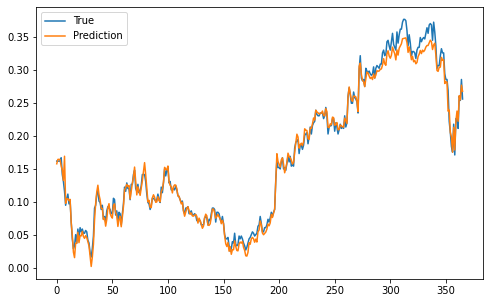

In [37]:
fig = plt.figure(facecolor='white', figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(test_y, label='True') # 실제 주가
ax.plot(pred, label='Prediction') # 딥러닝 모델이 예측한 주가
ax.legend()
ax